# Sentiment Analysis of Tweets

Sentiment Analysis of the tweets written in Serbian language on doiSerbia dataset.

## Connect to google drive

Connect to google drive so that we can save checkpoints and load the data

In [1]:
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


Change to directory where the notebook is located

In [2]:
%cd /content/google_drive/MyDrive/Colab\ Notebooks/Sentiment-Analysis-Roberta
%ls

/content/google_drive/MyDrive/Colab Notebooks/Sentiment-Analysis-Roberta
 checkpoints/          keys.txt               SA_dataset1.ipynb
 checkpoint_utils.py   model_utils.py         SA_dataset2.ipynb
 data/                 plot_utils.py          twitter_api_utils.py
 dataset.py           'previous notebooks'/
 dataset_utils.py      __pycache__/


In [3]:
import os
data_path = os.path.join(os.getcwd(),'data','dataset2')

## Split the data into train test and val and scuffle randomly

Data is randomly splitted into train, val and test sets with the percentage: 80%-10%-10%. When constructing these sets the same percentage is taken from all of the classes (positive, neutral and negative). That means that train set contains 80% of the positive examples, 80% of the negative examples and 80% of the neutral exampels (same logic can be applied to val and test sets).

Load the data

In [ ]:
from dataset_utils import preprocess_dataset2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def split_dfs(dfs):
    dfs_train = []
    dfs_val = []
    dfs_test = []
    for df in dfs:
        df = df.rename(columns={'sentiment1':'HandLabel'})
        n_rows = len(df)
        dfs_train.append(df.iloc[:int(0.8*n_rows),:])
        dfs_val.append(df.iloc[int(0.8*n_rows):int(0.9*n_rows),:])
        dfs_test.append(df.iloc[int(0.9*n_rows):,:])
    return pd.concat(dfs_train,ignore_index=True), pd.concat(dfs_val,ignore_index=True), pd.concat(dfs_test,ignore_index=True)

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'tweet_git.csv'))
df = preprocess_dataset2(df)
df.loc[df.sentiment1==0,'sentiment1'] = 'Negative' # negative
df.loc[df.sentiment1==2,'sentiment1'] = 'Neutral' # neutral
df.loc[df.sentiment1==4,'sentiment1'] = 'Positive' # positive
df_neg = df.loc[df.sentiment1=='Negative',:]
df_neutr = df.loc[df.sentiment1=='Neutral',:]
df_pos = df.loc[df.sentiment1=='Positive',:]

df_train, df_val, df_test = split_dfs([df_pos,df_neutr,df_neg])
print(f'Number of training examples: {len(df_train)}')
print(df_train.loc[:,['Tweet','HandLabel']].head())
print(f'Number of validation examples: {len(df_val)}')
print(df_val.loc[:,['Tweet','HandLabel']].head())
print(f'Number of test examples: {len(df_test)}')
print(df_test.loc[:,['Tweet','HandLabel']].head())

Number of training examples: 921
                                               Tweet HandLabel
0  odlični tekstovi i istraživanja  online o hara...  Positive
1  ako možete, gledajte/slušajte zg na  \nlekovit...  Positive
2  bravo za , još uvek ima onih koji se ne plaše ...  Positive
3  knjige lasla blaškovića na slovačkom i mađarsk...  Positive
4  10 najboljih poena u 2016.godini ! ???? ??????...  Positive
Number of validation examples: 114
                                               Tweet HandLabel
0  leskovac je dao primer koji bi mogli da da sle...  Positive
1    online  po broju učenika definitivno da je a...  Positive
2  lepa ideja grada leskovac, ovako se brine o na...  Positive
3  svaka riječ na svom mjestu. respect!  ex of   ...  Positive
4                                     dr briljira...  Positive
Number of test examples: 117
                                               Tweet HandLabel
0   tomy  nadam se da ste procitali tekst  ... iz...  Positive
1   tomy   mislim da 

Visulization of the distribution of the examples per class.

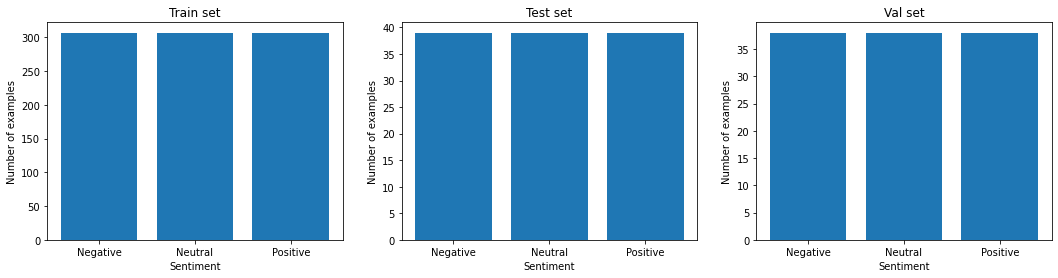

In [ ]:
from plot_utils import plot_example_distribution

plot_example_distribution(df_train, df_test, df_val)

Schuffle randomly

In [ ]:
from dataset_utils import schuffle_df

df_train = schuffle_df(df_train) 
df_test = schuffle_df(df_test) 
df_val = schuffle_df(df_val) 
print(df_train.loc[:,['Tweet','HandLabel']].head())
print(df_val.loc[:,['Tweet','HandLabel']].head())
print(df_test.loc[:,['Tweet','HandLabel']].head())

                                                 Tweet HandLabel
113      bgd \n\nneka budu po udobnim kancelarijama...  Positive
756  "a sve žene i sva djeca su uredno deportovani ...  Negative
325                                       online   dan   Neutral
440  novi video spot  grupe models/otmica. vidimo s...   Neutral
362                                      o tviteru na    Neutral
                                                 Tweet HandLabel
112   online spaskovski.gde ga samo nađoše majke ti...  Negative
74                               a sličnost sa kandić?   Neutral
17   i  i  tomy odlični na  u vezi sa potencijalnom...  Positive
58   ovaj i neki dan bio na  kakti predstavnik siri...   Neutral
36   retko kvalitetno saopstenje u poslednjih par g...  Positive
                                                Tweet HandLabel
82    online americku.....jebace vam mater putin.....  Negative
66                                          zasto mi?   Neutral
32                          

Cache datasets

In [ ]:
df_train.to_csv(os.path.join(data_path,'train.csv'))
df_val.to_csv(os.path.join(data_path,'val.csv'))
df_test.to_csv(os.path.join(data_path,'test.csv'))

## Load XLM-R model and sentencepiece tokenizer

For this task we will use XLM-R large model, which can be downloaded from pytorch hub and sentencepiece tokenizer which can be downloaded from hugging face package. 

Install dependencies for fairseq

In [ ]:
%pip install hydra-core
%pip install omegaconf
%pip install sentencepiece
%pip install transformers

Load XLM-R model

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from statistics import mean
import pickle

xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.large')

Load sentencepiece tokenizer

In [ ]:
from transformers import XLMRobertaTokenizer, AdamW, get_linear_schedule_with_warmup

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

## Complete model

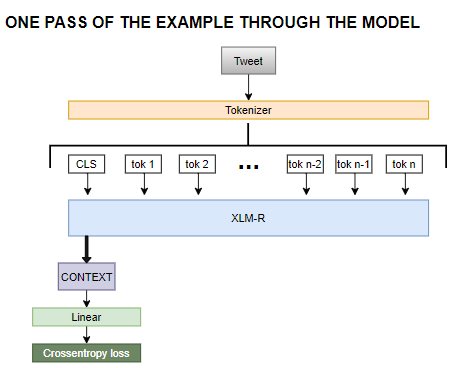

## Hyperparameters

In [ ]:
BATCH_SIZE = 8
EPOCHS = 500 # total number of epochs
DO = 0.5 # dropout
#=============================
# freeze xlmr hyperparams 
EPOCHS_FREEZE = 2
NUM_WARMUP_EPOCHS_FREEZE = 1
LR_FREEZE = 1e-4
#=============================
# unfreeze xlmr hyperparams
NUM_WARMUP_EPOCHS = 4
WEIGHT_DECAY = 1e-4
LR = 1e-6

## Train loop

In [ ]:
from dataset import MyDataset
from model_utils import wrap_tokenizer, train_step, val_step
from checkpoint_utils import save_to_disk, load_from_disk
from checkpoint_utils import save_checkpoint_dataset2 as save_checkpoint

In [ ]:
checkpoint_dir = os.path.join(os.getcwd(),'checkpoints','dataset2')
os.makedirs(checkpoint_dir, exist_ok=True)
print(f'Checkpoints will be saved at {checkpoint_dir}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
xlmr = xlmr.to(device)
classifier = nn.Linear(in_features=1024, out_features=3).to(device)
dropout = nn.Dropout(p=DO).to(device)
print('Number of trainable params: ',sum(p.numel() for p in xlmr.parameters())+\
      sum(p.numel() for p in classifier.parameters()))
# define Data Loaders
train_dataset = MyDataset(df_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = MyDataset(df_val)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = MyDataset(df_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# define optimizer
params = list(xlmr.parameters()) + list(classifier.parameters())
# start with frozen XLMR model (it should be left in train mode)
for p in xlmr.parameters():
    p.requires_grad=False
optimizer = AdamW(params, lr=LR_FREEZE)
# define learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=NUM_WARMUP_EPOCHS_FREEZE*len(train_loader),
    num_training_steps=EPOCHS_FREEZE*len(train_loader)
    )
# wrap tokenizer
tokenize = wrap_tokenizer(tokenizer)
logs = {'train_acc':[],'train_loss':[],'val_acc':[],'val_loss':[], 'lr':[]}
for epoch in range(EPOCHS):
    if epoch == EPOCHS_FREEZE:
        # unfreeze xlmr model
        for p in xlmr.parameters():
            p.requires_grad=True
        print('XLM-R model is unfrozen!')
        optimizer = AdamW(params, lr=LR, weight_decay=WEIGHT_DECAY)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=NUM_WARMUP_EPOCHS*len(train_loader),
            num_training_steps=(EPOCHS-EPOCHS_FREEZE)*len(train_loader)
            )
    train_acc, train_loss = train_step(
        train_loader=train_loader,
        tokenize=tokenize, 
        device=device, 
        optimizer=optimizer, 
        scheduler=scheduler,
        xlmr=xlmr,
        classifier=classifier,
        dropout = dropout,
        logs=logs
        )
    val_acc, val_loss = val_step(
        val_loader=val_loader,
        tokenize=tokenize, 
        device=device, 
        xlmr=xlmr,
        classifier=classifier,
        dropout=dropout
        )
    logs['train_acc'] += train_acc
    logs['train_loss'] += train_loss
    logs['val_acc'] += val_acc
    logs['val_loss'] += val_loss
    if epoch % 5 == 0 and epoch > 15:
        save_checkpoint(
            xlmr=xlmr,
            classifier=classifier, 
            optimizer=optimizer, 
            logs=logs, 
            checkpoint_dir=checkpoint_dir, 
            epoch=epoch
            )
    print('')
    print(f"Epoch {epoch} --> loss:{mean(train_loss):.4f},\
        acc:{mean(train_acc):.2f}%,\
        val_loss:{mean(val_loss):.4f},\
        val_acc:{mean(val_acc):.2f}%")

## Test

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from checkpoint_utils import load_checkpoint_dataset2 as load_checkpoint

### Load XLM-R model and sentencepiece tokenizer

Install dependencies for fairseq

In [ ]:
%pip install hydra-core
%pip install omegaconf
%pip install sentencepiece
%pip install transformers
%pip install fairseq

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer
import torch.nn as nn
from statistics import mean
import pickle
from model_utils import wrap_tokenizer

Before loading the model from torch hub go to: <br /> /usr/local/lib/python3.7/dist-packages/fairseq/modules/multihead_attention.py<br /> and change the default value for need_head_weights argument from False to True in the forward function. Do not forget to save the script.<br /> Now we can extract attention weights.

In [9]:
import fairseq
xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.large')
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

Downloading: "https://github.com/pytorch/fairseq/archive/master.zip" to /root/.cache/torch/hub/master.zip
100%|██████████| 1028340964/1028340964 [00:36<00:00, 28221658.99B/s]


### Load checkpoint and test set

In [10]:
#checkpoint_dir = os.path.join(os.getcwd(),'checkpoints','dataset2','do-05-wd-1e-4-lr-1e-6-72val-acc-70test-acc')
checkpoint_dir = os.path.join(os.getcwd(),'checkpoints','dataset2','do-04-wd-1e-4-lr-1e-6')

Load the model weights

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier = nn.Linear(in_features=1024, out_features=3)
dropout = nn.Dropout(p=0).to(device)
xlmr, classifier,_ = load_checkpoint(checkpoint_dir, 35, xlmr, classifier, device)
xlmr = xlmr.to(device)
classifier = classifier.to(device)
tokenize = wrap_tokenizer(tokenizer)

Initial loading failed. Trying with changed keys!
Weights are loaded successfuly!


Load test set

In [12]:
from dataset import MyDataset

test_path = os.path.join(data_path,'test.csv')
df_test = pd.read_csv(test_path)
test_dataset = MyDataset(df_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

### Accuracy on test set

In [ ]:
from model_utils import val_step

test_acc, test_loss, predictions, targets = val_step(
        val_loader=test_loader,
        tokenize=tokenize, 
        device=device, 
        xlmr=xlmr,
        classifier=classifier,
        dropout=dropout,
        is_test=True
        )
print('')
print(f"test loss:{mean(test_loss):.4f}\n test acc:{mean(test_acc):.2f}%")


Validating...
 iter: 15/15
test loss:0.7582
 test acc:0.72%


In [14]:
preds = np.concatenate(predictions)
labels = np.concatenate(targets)

### Confusion matrix

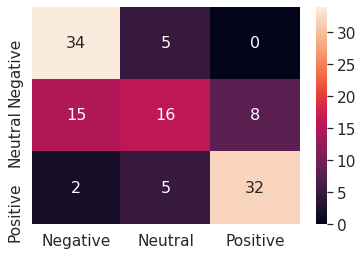

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds)
names = test_dataset.labels
df_cm = pd.DataFrame(cm, index=names, columns=names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

### Plot training curves

In [17]:
import os
from plot_utils import *
from checkpoint_utils import load_from_disk
 
logs = load_from_disk(os.path.join(checkpoint_dir,'logs.txt'))

In [18]:
SHOW_EPOCHS = 36
lr = logs['lr'][:116*(SHOW_EPOCHS-1)]
train_acc = average(logs['train_acc'],116)[:SHOW_EPOCHS]
val_acc = average(logs['val_acc'],15)[:SHOW_EPOCHS]
train_loss = average(logs['train_loss'],116)[:SHOW_EPOCHS]
val_loss = average(logs['val_loss'],15)[:SHOW_EPOCHS]

Show learning rate through epochs

Text(1856, 5e-05, 'Fine-Tuning')

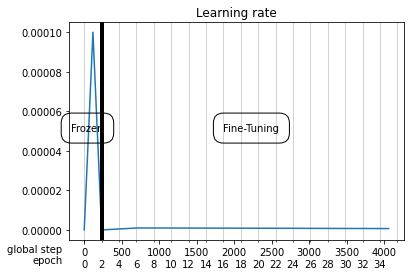

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(lr)
ax.set_title('Learning rate')
minor_ticks = np.arange(-1, 116*SHOW_EPOCHS, 116*2)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(labels=range(0,SHOW_EPOCHS,2),minor=True)
ax.grid(which='minor', alpha=0.7)
xax = ax.get_xaxis()
ax.set_xlabel('global step\nepoch',labelpad=-25,horizontalalignment='right', x=-0.02)
xax.set_tick_params(which='minor', pad=17)
ax.axvline(x=2*116, linewidth=4, color='black')
ax.text(116*(-1.5), 0.00005, 'Frozen', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
ax.text(116*16, 0.00005, 'Fine-Tuning', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

Plot accuracy

Text(1392, 5e-05, 'Fine-Tuning')

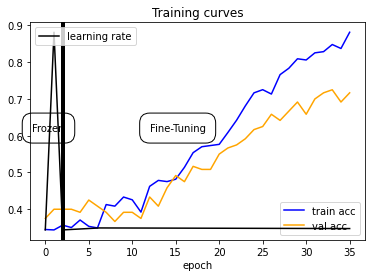

In [24]:
fig = plt.figure()
ax1=fig.add_subplot(111, label="1")
l1,=ax1.plot(train_acc,color='blue')
l2,=ax1.plot(val_acc,color='orange')
ax1.legend(['train acc','val acc'],loc='lower right')
ax=fig.add_subplot(111, label="3",frame_on=False)
ax.plot(lr, color='black')
ax.set_title('Training curves')
#ax.set_xlabel('epoch')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.legend(['learning rate'],loc='upper left')
plt.xlabel('epoch',labelpad=20)
ax.axvline(x=2*116, linewidth=4, color='black')
ax.text(116*(-1.5), 0.00005, 'Frozen', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
ax.text(116*12, 0.00005, 'Fine-Tuning', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

Plot loss

Text(1392, 5e-05, 'Fine-Tuning')

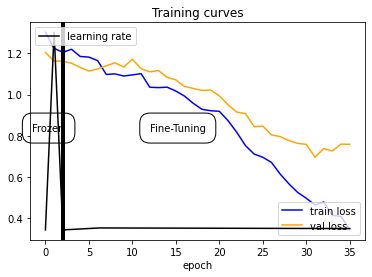

In [25]:
fig = plt.figure()
ax1=fig.add_subplot(111, label="1")
l1,=ax1.plot(train_loss,color='blue')
l2,=ax1.plot(val_loss,color='orange')
ax1.legend(['train loss','val loss'],loc='lower right')
ax=fig.add_subplot(111, label="3",frame_on=False)
ax.plot(lr, color='black')
ax.set_title('Training curves')
#ax.set_xlabel('epoch')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.legend(['learning rate'],loc='upper left')
plt.xlabel('epoch',labelpad=20)
ax.axvline(x=2*116, linewidth=4, color='black')
ax.text(116*(-1.5), 0.00005, 'Frozen', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
ax.text(116*12, 0.00005, 'Fine-Tuning', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

### Plot attentions

Attention plots for all layers are saved at /content/google_drive/My Drive/Colab Notebooks/Sentiment-Analysis-Roberta/checkpoints/dataset2/do-04-wd-1e-4-lr-1e-6/attentions
Tweet:   a ni  nije objavio celo pismo. sramno gaženje prema onome šta su predstavljali


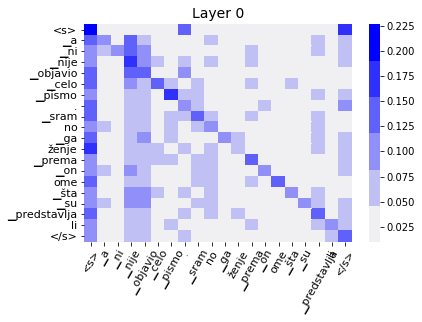

In [17]:
from checkpoint_utils import SaveOutput
from plot_utils import plot_attentions
import seaborn as sn

EXAMPLE_NUM = 20
LAYER_NUM = 0 # Layer to show
CMAP = sn.light_palette("blue")

attentions_dir = os.path.join(checkpoint_dir,'attentions')
os.makedirs(attentions_dir, exist_ok=True)
print(f'Attention plots for all layers are saved at {attentions_dir}')

example = df_test.Tweet[preds==labels].iloc[EXAMPLE_NUM:EXAMPLE_NUM+2]
print('Tweet: ', example.iloc[0])
tokens = tokenize(example)
tokens = tokens[0,:]
tokenized_text = tokenizer.convert_ids_to_tokens(tokens)
tokens = tokens.to(device)
tokenized_text = np.array(tokenized_text).ravel()
ids = (tokenized_text != '<pad>')

for i in range(24):
    save_output = SaveOutput()
    xlmr.model.encoder.sentence_encoder.layers[i].self_attn.register_forward_hook(save_output)
    with torch.no_grad():
        output = xlmr.extract_features(tokens, return_all_hiddens=True)
    att_weights = torch.squeeze(save_output.outputs[0][1])
    att_weights = att_weights[ids,:][:,ids]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plot_attentions(att_weights, tokenized_text[ids], ax, title='Layer {}'.format(i), cmap=CMAP)
    fig.savefig(os.path.join(attentions_dir,f'attention_{i}.png'))
    if i == LAYER_NUM:
        plt.show()
    else:
        plt.close()